In [1]:
#uncomment next line for google colab
#!curl -s https://course.fast.ai/setup/colab | bash

Cloning into 'DKFZ_Deep_Learning_Workshop'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 357 (delta 36), reused 7 (delta 3), pack-reused 291
Receiving objects: 100% (357/357), 39.69 MiB | 10.81 MiB/s, done.
Resolving deltas: 100% (153/153), done.


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.vision import *

In [7]:
!wget http://pjreddie.com/media/files/cifar.tgz

--2019-07-19 14:53:25--  http://pjreddie.com/media/files/cifar.tgz
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/cifar.tgz [following]
--2019-07-19 14:53:26--  https://pjreddie.com/media/files/cifar.tgz
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168584360 (161M) [application/octet-stream]
Saving to: ‘cifar.tgz’

cifar.tgz           100%[===================>] 160.77M  22.9MB/s    in 7.8s    

2019-07-19 14:53:34 (20.7 MB/s) - ‘cifar.tgz’ saved [168584360/168584360]



In [0]:
!tar -xzf cifar.tgz

cifar/  cifar.tgz  DKFZ_Deep_Learning_Workshop/  sample_data/


In [0]:
path = 'cifar/train'
#path.ls()
#path_anno = path/'annotations'
path_img = path
fnames = get_image_files(path_img)
np.random.seed(2)
pat = r'/\d+_([^/]+).png$'

In [11]:
fnames

[PosixPath('cifar/train/14970_truck.png'),
 PosixPath('cifar/train/3486_cat.png'),
 PosixPath('cifar/train/10686_airplane.png'),
 PosixPath('cifar/train/40965_bird.png'),
 PosixPath('cifar/train/33925_cat.png'),
 PosixPath('cifar/train/39931_bird.png'),
 PosixPath('cifar/train/11302_airplane.png'),
 PosixPath('cifar/train/45528_truck.png'),
 PosixPath('cifar/train/44131_frog.png'),
 PosixPath('cifar/train/43327_deer.png'),
 PosixPath('cifar/train/2482_dog.png'),
 PosixPath('cifar/train/46021_deer.png'),
 PosixPath('cifar/train/25627_cat.png'),
 PosixPath('cifar/train/31885_truck.png'),
 PosixPath('cifar/train/17408_horse.png'),
 PosixPath('cifar/train/10635_frog.png'),
 PosixPath('cifar/train/40971_automobile.png'),
 PosixPath('cifar/train/19932_bird.png'),
 PosixPath('cifar/train/11102_horse.png'),
 PosixPath('cifar/train/45769_automobile.png'),
 PosixPath('cifar/train/37695_horse.png'),
 PosixPath('cifar/train/14746_frog.png'),
 PosixPath('cifar/train/2210_deer.png'),
 PosixPath('cif

In [0]:
bs=256

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=32, bs=bs
                                  ).normalize()

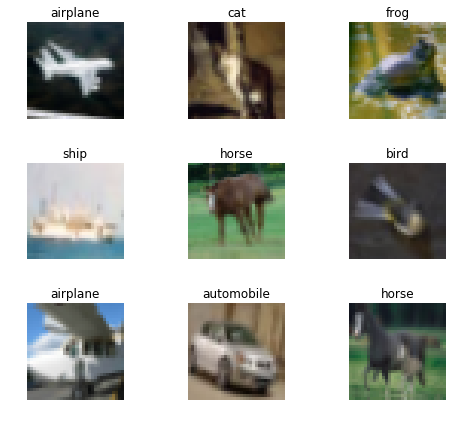

In [49]:
data.show_batch(rows=3, figsize=(7,6))


In [0]:
lr = 1e-2

In [0]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x

In [0]:
#def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
#model = nn.Sequential(
#    conv(3, 8), # 14
#    nn.BatchNorm2d(8),
#    nn.ReLU(),
#    conv(8, 16), # 7
#    nn.BatchNorm2d(16),
#    nn.ReLU(),
#    conv(16, 32), # 4
#    nn.BatchNorm2d(32),
#    nn.ReLU(),
#    conv(32, 16), # 2
#    nn.BatchNorm2d(16),
#    nn.ReLU(),
#    conv(16, 10), # 1
#    nn.BatchNorm2d(10),
#    Flatten()     # remove (1,1) grid
#)

In [0]:
model = SimpleNet([32*32*3,40,10])
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [53]:
learn.summary()

SimpleNet
Layer (type)         Output Shape         Param #    Trainable 
Linear               [40]                 122,920    True      
______________________________________________________________________
Linear               [10]                 410        True      
______________________________________________________________________

Total params: 123,330
Total trainable params: 123,330
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : CrossEntropyLoss
Callbacks functions applied 

In [54]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


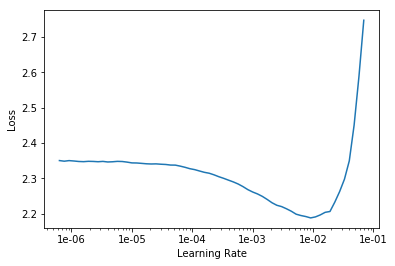

In [55]:
learn.recorder.plot()


In [56]:
learn.fit_one_cycle(2,max_lr = 5e-03)

epoch,train_loss,valid_loss,accuracy,time
0,1.789021,1.676875,0.418400,01:07
1,1.593406,1.533336,0.463200,01:06


In [57]:
learn.fit_one_cycle(2,max_lr = 1e-04)

epoch,train_loss,valid_loss,accuracy,time
0,1.538302,1.524333,0.465200,01:06
1,1.540443,1.520935,0.466400,01:06


In [0]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.out(x)

In [0]:
model = ConvNet([3,20,40,80],10)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [60]:
learn.summary()

ConvNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [20, 15, 15]         560        True      
______________________________________________________________________
Conv2d               [40, 7, 7]           7,240      True      
______________________________________________________________________
Conv2d               [80, 3, 3]           28,880     True      
______________________________________________________________________
AdaptiveMaxPool2d    [80, 1, 1]           0          False     
______________________________________________________________________
Linear               [10]                 810        True      
______________________________________________________________________

Total params: 37,490
Total trainable params: 37,490
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : Cross

In [61]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


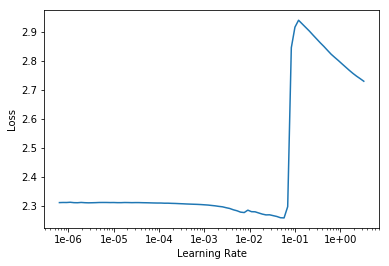

In [62]:
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(2,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.745054,1.593045,0.416500,01:07
1,1.475238,1.419021,0.481700,01:06


In [64]:
learn.fit_one_cycle(4,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.462269,1.436350,0.481100,01:06
1,1.423502,1.335543,0.517000,01:06
2,1.291016,1.236802,0.554000,01:06
3,1.209305,1.202216,0.567400,01:06


# Refactored


In [0]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [0]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x)

In [0]:
model = ConvNet2([3,20,40,80],10)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [68]:
learn.summary()

ConvNet2
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [20, 16, 16]         560        True      
______________________________________________________________________
Conv2d               [40, 8, 8]           7,240      True      
______________________________________________________________________
Conv2d               [80, 4, 4]           28,880     True      
______________________________________________________________________
Linear               [10]                 810        True      
______________________________________________________________________

Total params: 37,490
Total trainable params: 37,490
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : CrossEntropyLoss
Callbacks functions applied 

In [69]:
learn.fit_one_cycle(2,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.732502,1.638947,0.402900,01:06
1,1.449430,1.395810,0.499500,01:06


In [70]:
learn.fit_one_cycle(4,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.449880,1.475205,0.463800,01:06
1,1.398908,1.344050,0.513500,01:06
2,1.278704,1.284111,0.545600,01:06
3,1.178610,1.172812,0.583200,01:06


In [0]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [0]:

class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x)

In [0]:
model = ConvBnNet([10,20,40,80,160],10)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [74]:
learn.fit_one_cycle(2,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.466699,1.310829,0.526800,01:08
1,1.137227,1.071621,0.618200,01:08


In [75]:
learn.fit_one_cycle(4,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.173742,1.156947,0.591200,01:07
1,1.070739,1.045763,0.639500,01:08
2,0.904849,0.889216,0.698100,01:08
3,0.789235,0.821875,0.718700,01:08


In [0]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x)

In [0]:
model = ConvBnNet2([10,20,40,80,160],10)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [78]:
learn.fit_one_cycle(2,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.527538,1.396829,0.494100,01:09
1,1.144797,1.044662,0.632000,01:09


In [79]:
learn.fit_one_cycle(4,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.175606,1.169500,0.590300,01:09
1,1.033791,0.888126,0.695400,01:09
2,0.840851,0.809696,0.717700,01:09
3,0.692253,0.723214,0.745300,01:09


# Resnet

In [0]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [0]:
class Resnet(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return self.out(x)

In [0]:
model = Resnet([16,32,64,128,256],10,0.2)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [83]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


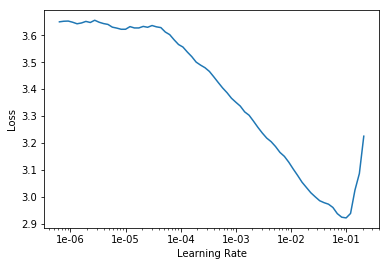

In [84]:
learn.recorder.plot()

In [85]:
learn.fit_one_cycle(10,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.779473,1.477279,0.468800,01:12
1,1.508280,1.454830,0.486600,01:12
2,1.303647,1.245166,0.572700,01:12
3,1.135495,0.969861,0.660100,01:12
4,0.994132,0.884694,0.696900,01:12
5,0.872205,0.801588,0.725100,01:12
6,0.766135,0.748282,0.744900,01:12
7,0.653859,0.644678,0.773100,01:13
8,0.578636,0.628734,0.777400,01:13
9,0.535426,0.599000,0.789700,01:13


In [86]:
learn.fit_one_cycle(4,max_lr = 5e-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.529523,0.601031,0.791100,01:13
1,0.528209,0.602944,0.791900,01:13
2,0.509355,0.595157,0.797800,01:13
3,0.496275,0.592824,0.798600,01:13
